In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Redes Neuronales

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

#Keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

<img src="australia.jpg">

Enrique Macip Belmonte y Maria Ruiz Teixidor

# 1. Introducción

Los datos usados para esta parte de la práctica son los mismos que en el apartado anterior y otras prácticas de ML. Los datos obtenidos de Kaggle tienen la información meteorológica de varios años en Australia, datos en los que viene incluida desde la velocidad del viento hasta la temperatura, en total 23 variables recogidas durante varios años en distintas ciudades de Australia con las que se obtienen un dataset de 140.000 líneas aproximadamente.

Nuestro objetivo será predecir si llueve o no el día siguiente a partir los datos metereológicos del día. Nos interesará tener una matriz de confusión dónde los verdaderos positivos y los verdaderos negativos sean altos. Sobretodo nos interesará que el modelo prediga bien los días en los que sí llueve el día siguiente: verdaderos positivos. Por lo que nos vamos a centrar en la sensibilidad para poder contestar a la pregunta ¿Qué proporción de días de lluvia se han identificado correctamente?

Con este dataset tan grande lo primero que nos planteamos fue centrarnos en dos cosas:

    Utilizar una zona concreta de Australia, sacada de la variable localización, de la cual elegimos 4 ciudades situadas en la costa sureste de Australia.

    Utilizar la variable temporal de alguna forma, ya que considerabamos que tenía importancia pero no podíamos usar cada día del año como un dato diferente, por lo que decidimos obtener a partir de la fecha la estación del año en la que estaba cada línea.

# 2. Lectura de datos

Los datasets son los que se han usado previamente en otras prácticas, de manera que ya están con la adecuada imputación de nulos y divididos correctamente. En este caso los tenemos ya normalizados y separados por variables dummies.

    80% training
    10% test
    10% validación


In [2]:
df_train = pd.read_csv("datasets/df_train_estand.csv") 
df_test = pd.read_csv("datasets/df_test_estand.csv") 

In [3]:
df_train.head(4)

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindDir3pm_N,WindDir3pm_SSW,WindDir3pm_SE,WindDir3pm_NNW,WindDir3pm_ENE,WindDir3pm_NW,WindDir3pm_WSW,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_SSE
0,1,1.105881,0.463667,0.172916,0.464414,0.457727,1.420500,0.570674,1.871575,0.853231,...,0,0,0,0,0,0,0,0,0,0
1,2,1.208613,0.369192,0.003670,0.106431,-1.670080,0.195810,1.135058,0.337745,0.267711,...,0,0,0,0,0,0,0,0,0,0
2,3,1.585297,1.077751,-0.306613,0.882061,1.806338,-0.596637,-0.332339,-0.252190,-0.552017,...,0,0,0,0,0,0,0,0,0,0
3,4,-0.109781,0.180243,-0.221990,-0.191888,0.337851,-0.308474,-0.558093,-1.196085,-0.259257,...,0,0,0,0,0,0,0,0,0,0


In [4]:
del df_train['Unnamed: 0']
del df_test['Unnamed: 0']

In [5]:
df_selected_train = df_train[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am','Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'Location_Canberra', 'Location_Adelaide', 'Location_Melbourne', 'Location_Sydney', 'Season_fall', 'Season_spring', 'Season_winter', 'Season_summer', 'RainTomorrow']]
df_selected_test = df_test[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am','Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'Location_Canberra', 'Location_Adelaide', 'Location_Melbourne', 'Location_Sydney', 'Season_fall', 'Season_spring', 'Season_winter', 'Season_summer', 'RainTomorrow']]

In [6]:
df_selected_train.head(4)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,RainToday,Location_Canberra,Location_Adelaide,Location_Melbourne,Location_Sydney,Season_fall,Season_spring,Season_winter,Season_summer,RainTomorrow
0,1.105881,0.463667,0.172916,0.464414,0.457727,1.420500,0.570674,1.871575,0.853231,0.591041,...,1,0,0,0,1,0,0,0,1,0
1,1.208613,0.369192,0.003670,0.106431,-1.670080,0.195810,1.135058,0.337745,0.267711,0.591041,...,1,0,0,0,1,1,0,0,0,1
2,1.585297,1.077751,-0.306613,0.882061,1.806338,-0.596637,-0.332339,-0.252190,-0.552017,-0.370259,...,0,0,1,0,0,0,0,0,1,0
3,-0.109781,0.180243,-0.221990,-0.191888,0.337851,-0.308474,-0.558093,-1.196085,-0.259257,-0.652995,...,0,0,0,1,0,0,1,0,0,0


Transformamos el dataframe a matrices.

In [7]:
X_train = df_selected_train.iloc[:, :-1].values 
y_train = df_selected_train.iloc[:, -1:].values
X_test = df_selected_test.iloc[:, :-1].values
y_test = df_selected_test.iloc[:, -1:].values

# 3. Ajuste de redes neuronales

Antes de comenzar con el ajuste, queríamos comentar que este es un dataset desbalanceado y que en este apartado no se balanceará en la red, pues se quiere ver cómo mejorarían los resultados en el apartado siguiente, balanceando los datos.

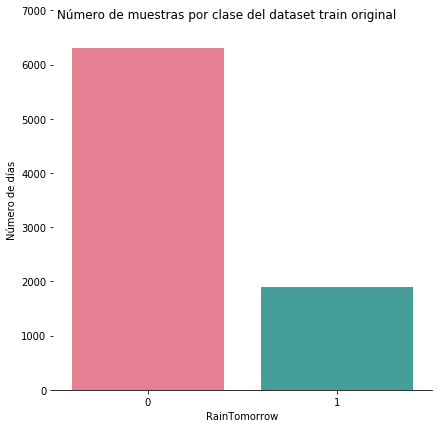

In [8]:
g = sns.catplot(x="RainTomorrow", data=df_selected_train, height=6, kind="count", palette="husl")
g.despine(left=True)
g.set_ylabels("Número de días")
g.fig.suptitle('Número de muestras por clase del dataset train original') 
plt.ylim(0, 7000)
plt.show()

## 3.1 Configuración 1 

En primer lugar, realizamos una prueba con una red neuronal secuencial y a partir de ésta vamos a ir cambiando las confuguraciones y ajustando. Hemos decidido empezar con una red de tres capas:

  - Capa inicial: dónde indicamos el número de variables entrantes y las neuronas (12). Función de activación Relu.
  - Capa intermedia: con 8 neuronas y función de activación relu.
  - Capa final: una única neurona y función de activación sigmoid ya que la salida de nuestro modelo tiene que ser binaria.

### Configuración de la red

In [9]:
model = Sequential()
model.add(Dense(12, input_dim=25, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                312       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 425
Trainable params: 425
Non-trainable params: 0
_________________________________________________________________


Compilamos la red neuronal, indicando las métricas que queremos obtener (accuracy, recall y precision), el optimizador y la función de coste:

In [11]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall,precision])

### Entrenamiento

Entrenamos la red con 150 épocas y un tamaño de batch = 10:

In [13]:
# fit the keras model on the dataset
X_train = np.asarray(X_train).astype(np.float32)
model_fitted = model.fit(X_train, y_train, epochs=150, batch_size=10)

Epoch 1/150
820/820 [==============================] - 1s 643us/step - loss: 0.4469 - accuracy: 0.8107 - recall: 0.3291 - precision: 0.6865
Epoch 2/150
820/820 [==============================] - 1s 625us/step - loss: 0.3800 - accuracy: 0.8380 - recall: 0.5148 - precision: 0.7030
Epoch 3/150
820/820 [==============================] - 1s 629us/step - loss: 0.3725 - accuracy: 0.8401 - recall: 0.5190 - precision: 0.7093
Epoch 4/150
820/820 [==============================] - 1s 633us/step - loss: 0.3680 - accuracy: 0.8438 - recall: 0.5307 - precision: 0.7180
Epoch 5/150
820/820 [==============================] - 1s 630us/step - loss: 0.3647 - accuracy: 0.8432 - recall: 0.5180 - precision: 0.7230
Epoch 6/150
820/820 [==============================] - 1s 633us/step - loss: 0.3613 - accuracy: 0.8468 - recall: 0.5317 - precision: 0.7304
Epoch 7/150
820/820 [==============================] - 1s 628us/step - loss: 0.3590 - accuracy: 0.8462 - recall: 0.5323 - precision: 0.7274
Epoch 8/150
820/820 

820/820 [==============================] - 1s 649us/step - loss: 0.3173 - accuracy: 0.8654 - recall: 0.5841 - precision: 0.7764
Epoch 117/150
820/820 [==============================] - 1s 645us/step - loss: 0.3164 - accuracy: 0.8672 - recall: 0.5852 - precision: 0.7838
Epoch 118/150
820/820 [==============================] - 1s 652us/step - loss: 0.3167 - accuracy: 0.8665 - recall: 0.5852 - precision: 0.7805
Epoch 119/150
820/820 [==============================] - 1s 649us/step - loss: 0.3156 - accuracy: 0.8667 - recall: 0.5942 - precision: 0.7750
Epoch 120/150
820/820 [==============================] - 1s 811us/step - loss: 0.3165 - accuracy: 0.8641 - recall: 0.5794 - precision: 0.7744
Epoch 121/150
820/820 [==============================] - 1s 703us/step - loss: 0.3167 - accuracy: 0.8650 - recall: 0.5862 - precision: 0.7732
Epoch 122/150
820/820 [==============================] - 1s 707us/step - loss: 0.3154 - accuracy: 0.8662 - recall: 0.5931 - precision: 0.7736
Epoch 123/150
820/82

Métricas obtenidas en el entrenamiento:

In [14]:
_, accuracy, recall, precision = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))
print('Recall: %.2f' % (recall*100))
print('Precision: %.2f' % (precision*100))

257/257 [==============================] - 0s 637us/step - loss: 0.3064 - accuracy: 0.8702 - recall: 0.5921 - precision: 0.7925
Accuracy: 87.02
Recall: 59.21
Precision: 79.25


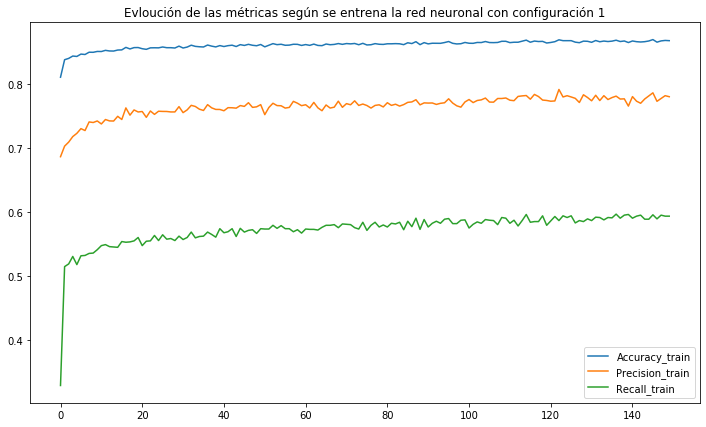

In [15]:
plt.figure(figsize=(12,7))
plt.title('Evloución de las métricas según se entrena la red neuronal con configuración 1')
plt.plot(model_fitted.history['accuracy'], label='Accuracy_train')
plt.plot(model_fitted.history['precision'], label='Precision_train')
plt.plot(model_fitted.history['recall'], label='Recall_train')
plt.legend()
plt.show()

### **Evaluación con el dataset Test**

Observamos que se obtiene un buen accuracy y precision pero el valor del recall es mejorable.

In [16]:
loss, accuracy_test, recall_test, precision_test = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy_test*100))
print('Recall: %.2f' % (recall_test*100))
print('Precision: %.2f' % (precision_test*100))

# estandarizando: Accuracy: 84.43, Recall: 52.14 (53 con más variables)

Accuracy: 84.82
Recall: 52.63
Precision: 71.86


## 3.2 Configuración 2

En segundo lugar, modificamos un poco la configuración de la red neuronal, simplificándola. Hemos probado otras configuraciones añadiendo más capas o probando otras funciones de activación pero no mejora significativamente. Hemos decidido empezar con una red de tres capas:

  - Capa inicial: número de variables entrantes y las neuronas(15). Función de activación Relu.
  - Capa final: una única neurona y función de activación sigmoid ya que la salida de nuestro modelo tiene que ser binaria.

### Configuración de la red

In [8]:
model2 = Sequential()
model2.add(Dense(15, input_dim=25, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [9]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


In [10]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [11]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall, precision])

### Entrenamiento

In [12]:
X_train = np.asarray(X_train).astype(np.float32)
model_fitted2 = model2.fit(X_train, y_train, epochs=150, batch_size=20)

Epoch 1/150
410/410 [==============================] - 0s 641us/step - loss: 0.4416 - accuracy: 0.8033 - recall: 0.4624 - precision: 0.5942
Epoch 2/150
410/410 [==============================] - 0s 652us/step - loss: 0.3809 - accuracy: 0.8378 - recall: 0.5011 - precision: 0.7099
Epoch 3/150
410/410 [==============================] - 0s 662us/step - loss: 0.3721 - accuracy: 0.8444 - recall: 0.5122 - precision: 0.7322
Epoch 4/150
410/410 [==============================] - 0s 645us/step - loss: 0.3679 - accuracy: 0.8468 - recall: 0.5148 - precision: 0.7416
Epoch 5/150
410/410 [==============================] - 0s 638us/step - loss: 0.3643 - accuracy: 0.8476 - recall: 0.5159 - precision: 0.7443
Epoch 6/150
410/410 [==============================] - 0s 616us/step - loss: 0.3614 - accuracy: 0.8494 - recall: 0.5238 - precision: 0.7472
Epoch 7/150
410/410 [==============================] - 0s 623us/step - loss: 0.3588 - accuracy: 0.8495 - recall: 0.5291 - precision: 0.7440
Epoch 8/150
410/410 

410/410 [==============================] - 0s 665us/step - loss: 0.3209 - accuracy: 0.8662 - recall: 0.5820 - precision: 0.7818
Epoch 118/150
410/410 [==============================] - 0s 662us/step - loss: 0.3216 - accuracy: 0.8661 - recall: 0.5783 - precision: 0.7841
Epoch 119/150
410/410 [==============================] - 0s 662us/step - loss: 0.3215 - accuracy: 0.8641 - recall: 0.5762 - precision: 0.7767
Epoch 120/150
410/410 [==============================] - 0s 662us/step - loss: 0.3209 - accuracy: 0.8639 - recall: 0.5804 - precision: 0.7725
Epoch 121/150
410/410 [==============================] - 0s 663us/step - loss: 0.3202 - accuracy: 0.8635 - recall: 0.5767 - precision: 0.7736
Epoch 122/150
410/410 [==============================] - 0s 662us/step - loss: 0.3209 - accuracy: 0.8638 - recall: 0.5778 - precision: 0.7739
Epoch 123/150
410/410 [==============================] - 0s 663us/step - loss: 0.3199 - accuracy: 0.8644 - recall: 0.5836 - precision: 0.7724
Epoch 124/150
410/41

In [13]:
_, accuracy, recall, precision = model2.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))
print('Recall: %.2f' % (recall*100))
print('Precison: %.2f' % (precision*100))

257/257 [==============================] - 0s 632us/step - loss: 0.3153 - accuracy: 0.8676 - recall: 0.6228 - precision: 0.7594
Accuracy: 86.76
Recall: 62.28
Precison: 75.94


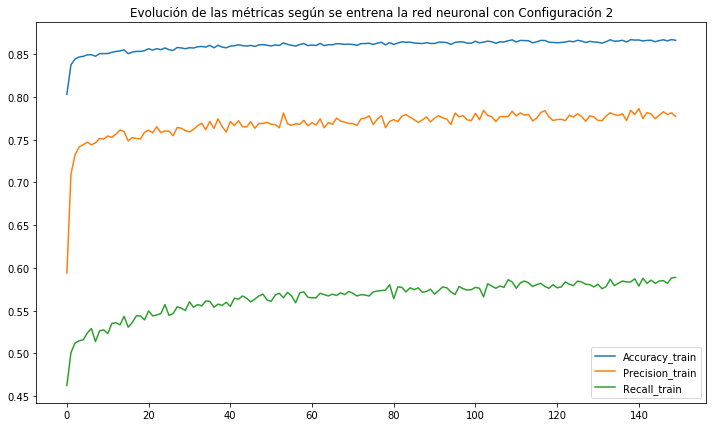

In [14]:
plt.figure(figsize=(12,7))
plt.title('Evolución de las métricas según se entrena la red neuronal con Configuración 2')
plt.plot(model_fitted2.history['accuracy'], label='Accuracy_train')
plt.plot(model_fitted2.history['precision'], label='Precision_train')
plt.plot(model_fitted2.history['recall'], label='Recall_train')
plt.legend()
plt.show()

### **Evaluación con el dataset Test**

Obervamos que obtenemos métricas parecidas pero con valores más altos, es mejor:

In [15]:
loss, accuracy_test, recall_test, precision_test = model2.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy_test*100))
print('Recall: %.2f' % (recall_test*100))
print('Precision: %.2f' % (precision_test*100))

Accuracy: 84.82
Recall: 57.46
Precision: 69.31


## 3.3 Configuración 3

En tercar lugar, modificamos un poco la configuración de la red neuronal, añadiendo **capas de dropout** para evitar el sobreajuste. 

  - Capa inicial: número de variables entrantes y las neuronas(15). Función de activación Relu.
  - Capa intermedia: capa dropout (probabilidad 0.2)
  - Capa final: una única neurona y función de activación sigmoid ya que la salida de nuestro modelo tiene que ser binaria.

### Configuración de la red

In [8]:
model3 = Sequential()
model3.add(Dense(15, input_dim=25, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))

In [9]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                390       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


In [10]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [11]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',recall, precision])

### Entrenamiento

In [12]:
X_train = np.asarray(X_train).astype(np.float32)
model_fitted3 = model3.fit(X_train, y_train, epochs=150, batch_size=20)

Epoch 1/150
410/410 [==============================] - 0s 642us/step - loss: 0.6393 - accuracy: 0.6980 - recall: 0.3693 - precision: 0.3522
Epoch 2/150
410/410 [==============================] - 0s 609us/step - loss: 0.4331 - accuracy: 0.8145 - recall: 0.4397 - precision: 0.6427
Epoch 3/150
410/410 [==============================] - 0s 641us/step - loss: 0.4029 - accuracy: 0.8238 - recall: 0.4783 - precision: 0.6632
Epoch 4/150
410/410 [==============================] - 0s 639us/step - loss: 0.3914 - accuracy: 0.8315 - recall: 0.4810 - precision: 0.6939
Epoch 5/150
410/410 [==============================] - 0s 890us/step - loss: 0.3867 - accuracy: 0.8350 - recall: 0.4958 - precision: 0.7008
Epoch 6/150
410/410 [==============================] - 0s 734us/step - loss: 0.3813 - accuracy: 0.8421 - recall: 0.5132 - precision: 0.7212
Epoch 7/150
410/410 [==============================] - 0s 731us/step - loss: 0.3772 - accuracy: 0.8391 - recall: 0.5069 - precision: 0.7123
Epoch 8/150
410/410 

410/410 [==============================] - 0s 633us/step - loss: 0.3421 - accuracy: 0.8555 - recall: 0.5307 - precision: 0.7709
Epoch 118/150
410/410 [==============================] - 0s 640us/step - loss: 0.3387 - accuracy: 0.8571 - recall: 0.5370 - precision: 0.7736
Epoch 119/150
410/410 [==============================] - 0s 631us/step - loss: 0.3403 - accuracy: 0.8530 - recall: 0.5238 - precision: 0.7645
Epoch 120/150
410/410 [==============================] - 0s 633us/step - loss: 0.3385 - accuracy: 0.8544 - recall: 0.5233 - precision: 0.7715
Epoch 121/150
410/410 [==============================] - 0s 635us/step - loss: 0.3400 - accuracy: 0.8551 - recall: 0.5259 - precision: 0.7729
Epoch 122/150
410/410 [==============================] - 0s 629us/step - loss: 0.3382 - accuracy: 0.8568 - recall: 0.5392 - precision: 0.7708
Epoch 123/150
410/410 [==============================] - 0s 632us/step - loss: 0.3398 - accuracy: 0.8529 - recall: 0.5259 - precision: 0.7623
Epoch 124/150
410/41

In [13]:
_, accuracy, recall, precision = model3.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))
print('Recall: %.2f' % (recall*100))
print('Precision: %.2f' % (precision*100))

257/257 [==============================] - 0s 630us/step - loss: 0.3200 - accuracy: 0.8655 - recall: 0.5291 - precision: 0.8244
Accuracy: 86.55
Recall: 52.91
Precision: 82.44


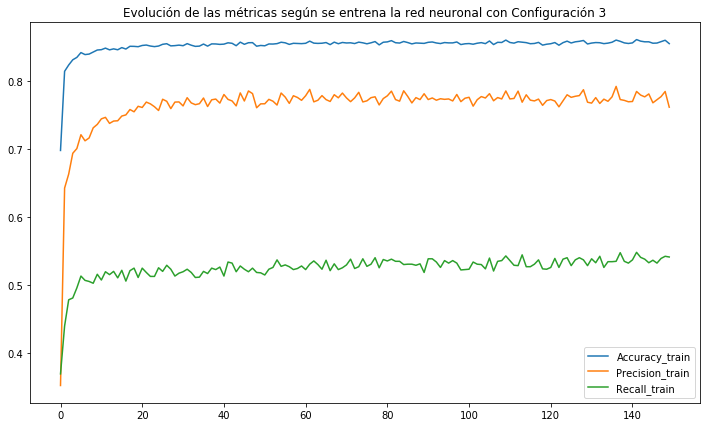

In [14]:
plt.figure(figsize=(12,7))
plt.title('Evolución de las métricas según se entrena la red neuronal con Configuración 3')
plt.plot(model_fitted3.history['accuracy'], label='Accuracy_train')
plt.plot(model_fitted3.history['precision'], label='Precision_train')
plt.plot(model_fitted3.history['recall'], label='Recall_train')
plt.legend()
plt.show()

### **Evaluación con el dataset Test**

Obervamos que mejora el precision pero empeora el recall:

In [15]:
loss, accuracy_test, recall_test, precision_test = model3.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy_test*100))
print('Recall: %.2f' % (recall_test*100))
print('Precision: %.2f' % (precision_test*100))

Accuracy: 84.23
Recall: 46.49
Precision: 73.10


# 4. Conclusiones

Con este ejercicio se concluye que la mejor **configuración probada es la 2**, aunque sea más sencilla y con menos capas es la que proporciona las mejores métricas precision - recall. Además, los resultados ya son muy buenos teniendo en cuenta que el dataset está desbalanceado y que podrán mejorar aplicando la adecuada técnica de balanceo. 

Como el siguiente ejercicio trata de cómo mejoran los modelos desequilibrados realizando un correcto tratamiento del número de muestras para cada clase, avanzamos en este apartado un pequeño **ejercicio de equilibrado** de muestras con la red neuronal con configuración 2 para evaluar cómo se llegarían a mejorar los resultados.

# 5. Matriz de costes (datos desbalanceados)

## Configuración 4

Partimos de la red neuronal con configuración 2:

  - Capa inicial: número de variables entrantes y las neuronas(15). Función de activación Relu.
  - Capa final: una única neurona y función de activación sigmoid ya que la salida de nuestro modelo tiene que ser binaria.

### Configuración de la red

In [8]:
df_selected_train.groupby(['RainTomorrow'])['MinTemp'].count()

RainTomorrow
0    6310
1    1890
Name: MinTemp, dtype: int64

In [9]:
muestras_clase0 =  6310
muestras_clase1 =   1890
n_muestras = 6310 + 1890

Calculamos los pesos que tienen las clases en el dataset:

In [10]:
Pr_0 = muestras_clase0/n_muestras
Pr_1 = muestras_clase1/n_muestras

Definimos una matriz de costes:

In [11]:
weight = np.zeros((y_train.shape[0])) 
for i in range(0,y_train.shape[0]):
    if(y_train[i]==0):
        weight[i] = Pr_1/Pr_0
    if(y_train[i]==1):
        weight[i] = 1

Resumen de la red neuronal:

In [12]:
model2 = Sequential()
model2.add(Dense(15, input_dim=25, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [13]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


In [14]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

In [15]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', recall, precision])

### Entrenamiento

In [16]:
X_train = np.asarray(X_train).astype(np.float32)
model_fitted_weight = model2.fit(X_train, y_train, epochs=150, batch_size=20, sample_weight = weight)

Epoch 1/150
410/410 [==============================] - 0s 651us/step - loss: 0.2788 - accuracy: 0.6457 - recall: 0.7608 - precision: 0.3696
Epoch 2/150
410/410 [==============================] - 0s 815us/step - loss: 0.2259 - accuracy: 0.7711 - recall: 0.7508 - precision: 0.5023
Epoch 3/150
410/410 [==============================] - 0s 717us/step - loss: 0.2191 - accuracy: 0.7815 - recall: 0.7577 - precision: 0.5177
Epoch 4/150
410/410 [==============================] - 0s 711us/step - loss: 0.2157 - accuracy: 0.7822 - recall: 0.7577 - precision: 0.5188
Epoch 5/150
410/410 [==============================] - 0s 701us/step - loss: 0.2138 - accuracy: 0.7868 - recall: 0.7614 - precision: 0.5260
Epoch 6/150
410/410 [==============================] - 0s 707us/step - loss: 0.2116 - accuracy: 0.7854 - recall: 0.7672 - precision: 0.5235
Epoch 7/150
410/410 [==============================] - 0s 636us/step - loss: 0.2104 - accuracy: 0.7901 - recall: 0.7688 - precision: 0.5309
Epoch 8/150
410/410 

410/410 [==============================] - 0s 652us/step - loss: 0.1816 - accuracy: 0.8162 - recall: 0.8138 - precision: 0.5711
Epoch 118/150
410/410 [==============================] - 0s 651us/step - loss: 0.1810 - accuracy: 0.8196 - recall: 0.8180 - precision: 0.5767
Epoch 119/150
410/410 [==============================] - 0s 650us/step - loss: 0.1817 - accuracy: 0.8200 - recall: 0.8111 - precision: 0.5781
Epoch 120/150
410/410 [==============================] - 0s 646us/step - loss: 0.1807 - accuracy: 0.8217 - recall: 0.8180 - precision: 0.5803
Epoch 121/150
410/410 [==============================] - 0s 655us/step - loss: 0.1811 - accuracy: 0.8185 - recall: 0.8079 - precision: 0.5758
Epoch 122/150
410/410 [==============================] - 0s 662us/step - loss: 0.1812 - accuracy: 0.8215 - recall: 0.8085 - precision: 0.5810
Epoch 123/150
410/410 [==============================] - 0s 670us/step - loss: 0.1807 - accuracy: 0.8227 - recall: 0.8233 - precision: 0.5815
Epoch 124/150
410/41

In [17]:
_, accuracy, recall, precision = model2.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))
print('Recall: %.2f' % (recall*100))
print('Precision: %.2f' % (precision*100))

257/257 [==============================] - 0s 621us/step - loss: 0.3726 - accuracy: 0.8337 - recall: 0.8005 - precision: 0.6052
Accuracy: 83.37
Recall: 80.05
Precision: 60.52


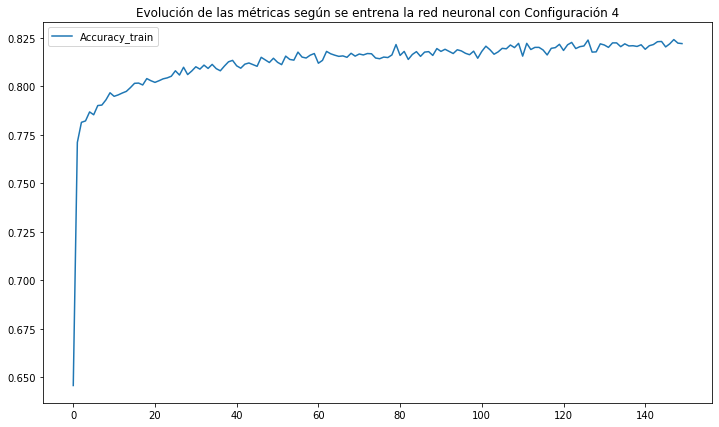

In [19]:
plt.figure(figsize=(12,7))
plt.title('Evolución de las métricas según se entrena la red neuronal con Configuración 4')
plt.plot(model_fitted_weight.history['accuracy'], label='Accuracy_train')
#plt.plot(model_fitted_weight.history[precision], label='Precision_train')
#plt.plot(model_fitted_weight.history[recall], label='Recall_train')
plt.legend()
plt.show()

### **Evaluación con el dataset Test**

Efectivamente vemos que los resultados mejoran mucho una vez se ha aplicado la matriz de costes: se pensaliza equivocarse los días en los que llueve y no se acerta acertar más los días en los que llueve que los días en los que no llueve.

In [20]:
loss, accuracy_test, recall_test, precision_test = model2.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy_test*100))
print('Recall: %.2f' % (recall_test*100))
print('Precision: %.2f' % (precision_test*100))

Accuracy: 79.73
Recall: 71.05
Precision: 53.47


In [21]:
#Guardar en HTML
!jupyter nbconvert Redes_Neuronales.ipynb --to html --log-level WARN